# Demo notebook for a differentiable statistical model

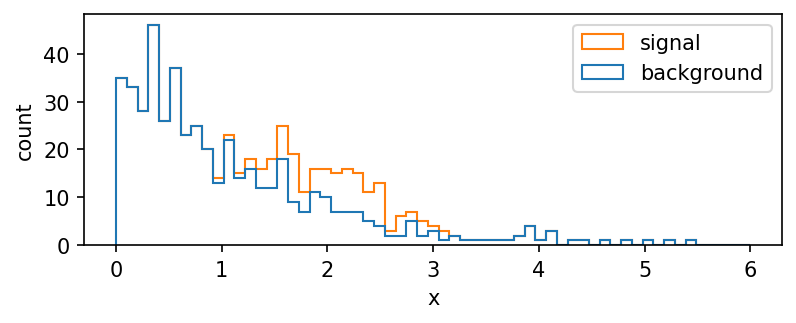

In [121]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import relaxed

# matplotlib settings
plt.rc("figure", figsize=(6, 2), dpi=150, facecolor="w")

# generate background data from an exponential distribution with a little noise
def generate_background(key, n_samples, n_features, noise_std):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.exponential(subkey, (n_samples, n_features))
    key, subkey = jax.random.split(key, 2)
    data += jax.random.normal(subkey, (n_samples, n_features)) * noise_std
    return data


# generate signal data from a normal distribution close to the background
def generate_signal(key, n_samples, n_features):
    key, subkey = jax.random.split(key, 2)
    data = jax.random.normal(subkey, (n_samples, n_features)) / 2 + 2
    return data


# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 500, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

sig = sig[sig>0]
bkg = bkg[bkg>0]

# plot!
plt.hist(
    [bkg, sig], stacked=True, bins=jnp.linspace(0,6,60), histtype="step", label=["background", "signal"]
)
plt.xlabel("x")
plt.ylabel("count")
plt.legend();

# Optimize binning window on data given a number of bins for lowest signal uncertainty

In [120]:
from histfactory import HEPDataLike  # differentiable model with just shapesys

# get 1000 samples from the background and 100 samples from the signal
bkg = generate_background(PRNGKey(0), 500, 1, 0.1).ravel()
sig = generate_signal(PRNGKey(1), 100, 1).ravel()

sig = sig[sig>0]
bkg = bkg[bkg>0]

In [124]:
from jaxopt import LBFGSB


def pipeline(lower_edge, bandwidth=1e-3, num_bins=4):
    # make num_bins uniformly spaced bins from lower_edge to lower_edge+1
    # basically sliding a small window over the data to make the histogram
    bins = jnp.linspace(lower_edge, lower_edge+1, num_bins+1)
    sig_h = relaxed.hist(sig, bins, bandwidth=bandwidth)
    bkg_h = relaxed.hist(bkg, bins, bandwidth=bandwidth)
    bkg_uncert = jnp.sqrt(bkg_h)
    model = HEPDataLike(sig_h, bkg_h, bkg_uncert)
    mle_pars = {"mu": jnp.array(0.), "shapesys": jnp.array([1.0 for _ in bkg_h])}
    data = model.expected_data(mle_pars)
    return relaxed.cramer_rao_uncert(model, mle_pars, data)["mu"]


def run_solve(init, bandwidth=1e-3, num_bins=4):
    fun = lambda x: pipeline(x, bandwidth=bandwidth, num_bins=num_bins)
    solver = LBFGSB(fun=fun)
    return solver.run(jnp.array(init), bounds=(0,6))[0]

In [125]:
run_solve(init=2.0)

Array(1.5609513, dtype=float64)

In [107]:
# do it for many bandwidths
bws = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
res = jax.vmap(jax.vmap(run_solve, in_axes=(0, None)), in_axes=(None, 0))(jnp.linspace(0,6,100), jnp.array(bws))

In [128]:
fun = lambda x: pipeline(x, bandwidth=1e-10, num_bins=4)
grid = jnp.linspace(0, 6, 1000)
sols = jax.vmap(fun)(grid)
best = grid[jnp.argmin(sols[jnp.isfinite(sols)])]

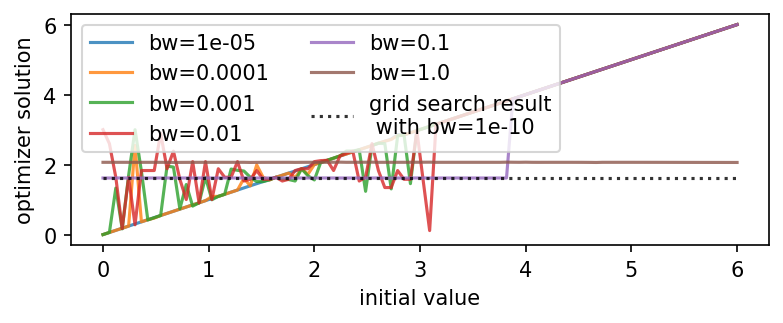

In [129]:
for i in range(len(bws)):
    plt.plot(jnp.linspace(0,6,100), res[i], label=f"bw={bws[i]}", alpha=0.8)
plt.hlines(best,0,6,linestyles=":",color="k", label="grid search result\n with bw=1e-10", alpha=0.8)
plt.legend(ncol=2)
plt.xlabel("initial value")
plt.ylabel("optimizer solution");